In [ ]:
!pip install pykeen matplotlib -q

In [ ]:
import torch
import matplotlib.pyplot as plt
from pykeen.pipeline import pipeline
from pykeen.evaluation import ClassificationEvaluator
from pykeen.datasets import Nations, Kinships
from pykeen.predict import predict_target

In [ ]:
# Load the Nations dataset
nations_dataset = Nations()

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Metrics storage
roc_auc_score = []
precision = []
accuracy = []
f1 = []

# Store results for different pipelines
pipeline_results_list = []

# Use ClassificationEvaluator for metrics calculation
evaluator = ClassificationEvaluator()

# Train the ComplEx model for different epochs and calculate metrics
epochs = [1, 20, 50, 100, 250]
for epoch in epochs:
    pipeline_results = pipeline(
        model="ComplEx",
        dataset=nations_dataset,
        training_kwargs=dict(num_epochs=epoch),
        device=device
    )
    pipeline_results_list.append(pipeline_results)

    model = pipeline_results.model
    metrics = evaluator.evaluate(
        model,
        nations_dataset.testing.mapped_triples,
        additional_filter_triples=[
            nations_dataset.training.mapped_triples,
            nations_dataset.validation.mapped_triples
        ]
    )

    roc_auc_score.append(metrics.get_metric('roc_auc_score'))
    precision.append(metrics.get_metric('average_precision_score'))
    accuracy.append(metrics.get_metric('accuracy_score'))
    f1.append(metrics.get_metric('f1_score'))

# Visualize metrics for different epochs
labels = epochs
plt.plot(labels, roc_auc_score, label='ROC_AUC')
plt.plot(labels, precision, label='Precision')
plt.plot(labels, accuracy, label='Accuracy')
plt.plot(labels, f1, label='F1')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Scores')
plt.title('Model Evaluation Metrics')
plt.show()

# Use predict_target for link prediction
for idx, ep in enumerate(epochs):
    pipeline_result = pipeline_results_list[idx]
    pred = predict_target(
        model=pipeline_result.model,
        head="uk",
        relation="conferences",
        triples_factory=pipeline_result.training,
    )
    pred_filtered = pred.filter_triples(nations_dataset.training)
    pred_annotated = pred_filtered.add_membership_columns(
        validation=nations_dataset.validation,
        testing=nations_dataset.testing
    )
    pred_df = pred_annotated.df[['tail_label', 'score']]
    print(f'Results for {ep} epochs')
    print(pred_df)
    print('__________________________')


```
Results for 1 epochs
   tail_label      score
12        usa  51.604752
2       china   1.644289
11         uk  -1.451728
6   indonesia  -2.339387
4       egypt  -5.735286
8      jordan -10.942652
0      brazil -22.322247
7      israel -24.502533
__________________________
Results for 20 epochs
   tail_label      score
12        usa  36.222778
0      brazil  26.496141
2       china  18.738447
4       egypt  13.143799
8      jordan  12.141767
7      israel   9.284089
6   indonesia  -0.569934
11         uk  -6.411471
__________________________
Results for 50 epochs
   tail_label      score
11         uk  27.716372
7      israel  10.844025
2       china   9.223184
0      brazil   4.717310
4       egypt   1.872037
12        usa  -9.173347
6   indonesia -44.041180
8      jordan -49.572029
__________________________
Results for 100 epochs
   tail_label      score
0      brazil  18.452913
12        usa  16.254860
4       egypt  13.122816
7      israel   2.302341
11         uk -10.556973
8      jordan -11.609539
6   indonesia -24.397144
2       china -41.063538
__________________________
Results for 250 epochs
   tail_label      score
4       egypt  16.651848
6   indonesia   4.358698
0      brazil  -6.566275
8      jordan -10.528923
7      israel -12.030392
2       china -12.823778
12        usa -18.414192
11         uk -40.645420
__________________________
```
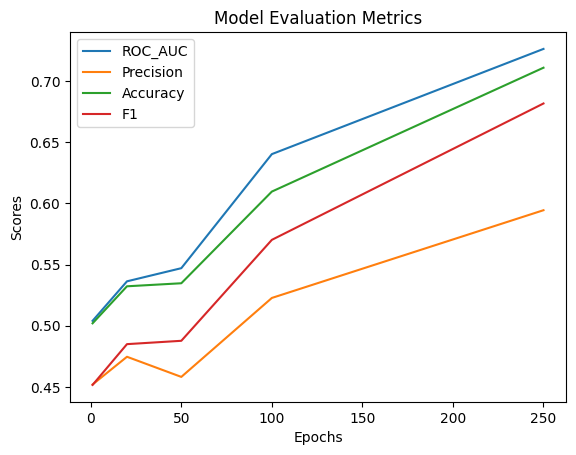

In [7]:
from pykeen.datasets import WN18
import torch
from pykeen.pipeline import pipeline
from pykeen.predict import predict_target

# Load the WN18 dataset
wn18_dataset = WN18()

# Get a sample triple from the dataset
sample_triple = wn18_dataset.training.mapped_triples[0]

# Extract the head, relation, and tail indices from the sample triple
head_idx, relation_idx, tail_idx = sample_triple.tolist()

# Get the corresponding entity and relation names
head_name = wn18_dataset.training.entity_id_to_label[head_idx]
relation_name = wn18_dataset.training.relation_id_to_label[relation_idx]
tail_name = wn18_dataset.training.entity_id_to_label[tail_idx]

print(f"Sample triple (head, relation, tail): ({head_name}, {relation_name}, {tail_name})")

INFO:pykeen.datasets.base:Requesting dataset from https://everest.hds.utc.fr/lib/exe/fetch.php?media=en:wordnet-mlj12.tar.gz
INFO:pykeen.datasets.base:Extracted to /root/.data/pykeen/datasets/wn18.


Sample triple (head, relation, tail): (00001740, _also_see, 00004227)


In [ ]:
# Train a model on the WN18 dataset
wn18_pipeline_result = pipeline(
    model="TransE",
    dataset=wn18_dataset,
    training_kwargs=dict(num_epochs=100),
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

# Choose an existing link to remove and predict the missing link
removed_link = (head_name, relation_name, tail_name)  # Use the sample triple as the removed link

# Get the index of the head, relation, and tail from the triples factory
head_idx = wn18_pipeline_result.training.entity_to_id[removed_link[0]]
relation_idx = wn18_pipeline_result.training.relation_to_id[removed_link[1]]
tail_idx = wn18_pipeline_result.training.entity_to_id[removed_link[2]]

# Create a tensor for the removed link using the indices
removed_link_idx = torch.tensor([head_idx, relation_idx, tail_idx])

# Create a mask to filter out the removed link
mask = ~torch.all(wn18_pipeline_result.training.mapped_triples == removed_link_idx, dim=1)

# Apply the mask to the mapped_triples to remove the specified link
wn18_pipeline_result.training.mapped_triples = wn18_pipeline_result.training.mapped_triples[mask]

# Predict the removed link
pred_removed_link = predict_target(
    model=wn18_pipeline_result.model,
    head=removed_link[0],
    relation=removed_link[1],
    triples_factory=wn18_pipeline_result.training,
)

# Analyze the results
print("Predicted scores for the removed link:")
print(pred_removed_link)

```
Predicted scores for the removed link:
TargetPredictions(df=       tail_id      score tail_label
0            0  -1.485123   00001740
20793    20793  -4.204930   05200169
5            5  -4.438059   00002573
20          20  -4.689478   00005041
2            2  -4.840541   00002137
...        ...        ...        ...
12887    12887 -10.466248   02260085
6115      6115 -10.479871   01104637
3525      3525 -10.480207   00639998
14334    14334 -10.489202   02500902
9830      9830 -10.590490   01754370
```